# <center>2. Clusterisation</center>

- KMeans and KMeans++ realisation;
- KMeans and Hierarchical clustering appication on test dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import colors
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
##### Jupyter notebook theme setup:
# !pip install jupyterthemes
!jt -t gruvboxd -fs 95 -tfs 11 -nfs 115 -cellw 80% -T
##### Reset theme:
# !jt -r
##### Plot style:
from jupyterthemes import jtplot
jtplot.style()

# Reload page after cell evaluation

# Task 1. KMeans.

### Centroids initialization methods

In [3]:
# "Forge" and "++ starting centroids generation methods
def generate_centroids(X, K, random_state):
    return X.sample(n=K, random_state=random_state).reset_index(drop=True)


def generate_centroids_plusplus(X, K, random_state):
    centroids = X.sample(n=1, random_state=random_state).reset_index(drop=True)
    distances = pd.DataFrame(range(len(X)))
    for x in range(1, K):
        for c in range(x):
            distances[c] = (X - centroids.loc[c]).apply(np.linalg.norm, axis=1)
        centroids = centroids.append(X.sample(n=1, random_state=random_state, weights=distances.min(axis=1)),
                                     ignore_index=True,)
    return centroids.reset_index(drop=True)

# kmeans

In [4]:
def my_Kmeans_vector(data: pd.DataFrame, K: int,
                     random_state=3, max_it=100, epsilon=10**-3, centroids_generator=generate_centroids):
    X = data.copy()
    n, p = X.shape
    centroid_names = ['centroid_{}'.format(c) for c in range(K)]
    
    centroids = centroids_generator(X, K, random_state=random_state)
    X['label'] = "centroid_-1"
    
    for it in range(max_it):
        centroid_change = 0.
        for c in range(K):
            X[centroid_names[c]] = (X.iloc[:, :p] - centroids.loc[c]).apply(np.linalg.norm, axis=1)
        X['label'] = X[centroid_names].idxmin(axis = 1)
        for c in range(K):
            tmp_centroid = X[X['label'] == centroid_names[c]].iloc[:, :p].mean()
            centroid_change += np.linalg.norm(centroids.loc[c] - tmp_centroid)
            centroids.loc[c] = tmp_centroid.copy()
        if centroid_change < epsilon:
            break
    # return tuple: labels, centroid coords, iterations
    return X['label'].map(lambda x: int(x.split('_')[-1])), centroids, it
    

### Input data generation

In [5]:
K, N, p = 10, 2000, 2
X_blobs, y_blobs = make_blobs(n_samples=N, n_features=p,
                              centers=K, cluster_std=1,
                              shuffle=True, random_state=7)
X_blobs = pd.DataFrame(X_blobs)
y_blobs = pd.Series(y_blobs)

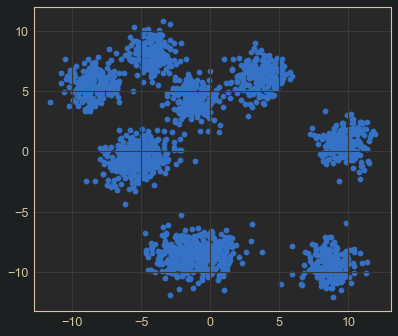

In [6]:
X = X_blobs.copy()
y = y_blobs.copy()
plt.scatter(X[0], X[1])

### kmeans vs kmeans++

Let $\epsilon$ threshold be 10**-4

In [7]:
%%time
# kmeans
labels_vector, centers_vector, it_vector = my_Kmeans_vector(
    X, K, max_it=1000
    , random_state=17
    , epsilon=10**-4
)

Wall time: 12.7 s


In [8]:
%%time
# kmeans++
labels_vector_plusplus, centers_vector_plusplus, it_vector_plusplus = my_Kmeans_vector(
    X, K, max_it=1000
    , epsilon=10**-4
    , random_state=7
    , centroids_generator=generate_centroids_plusplus
)

Wall time: 4.77 s


kmeans++ converged ~2 times faster

### Visualisation

In [9]:
def visualize_kmeans(labels, title):
    plt.scatter(X[0], X[1], c=labels)
    plt.title(title)
    print('ARI: %.4f' % metrics.adjusted_rand_score(y, labels))
    plt.show()

ARI: 0.6992


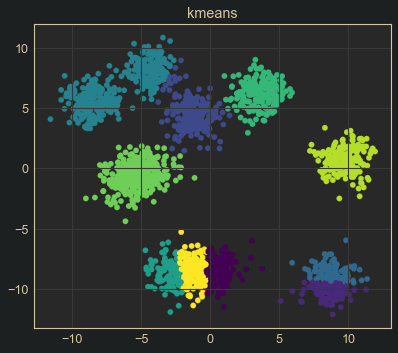

ARI: 0.7483


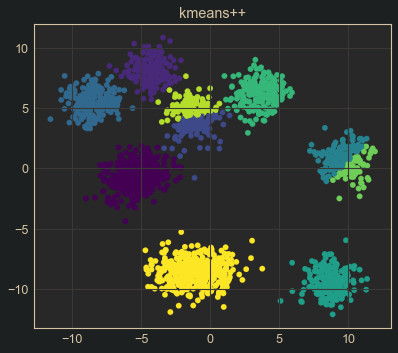

In [10]:
# kmeans
visualize_kmeans(labels_vector, 'kmeans')
# kmeans++
visualize_kmeans(labels_vector_plusplus, 'kmeans++')

Another random_seed could give better result.

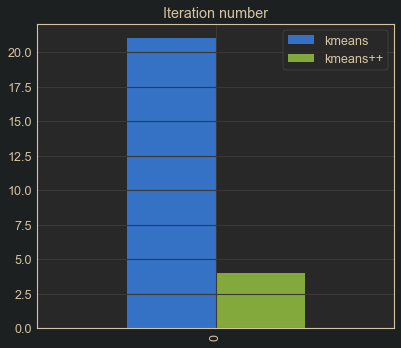

In [11]:
(
    pd.DataFrame(data={'kmeans': [it_vector], 'kmeans++': [it_vector_plusplus]})
    .plot.bar(title='Iteration number', width=0.5, align='center')
);

# Task 2. Dataset german_credit_data.csv.

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)


In [12]:
df_credits = pd.read_csv('data/german_credit_data.csv', sep=',', index_col=0)

In [13]:
df_credits.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education


Lets find some clusters, and interpret them aposteriori.

## Data Transforming

In [14]:
# Lets replace (manually) all categorical features to numeric code.
df_credits['Sex'] = df_credits['Sex'].map({'male': 1, 'female': 0})
df_credits['Housing'] = df_credits['Housing'].map({'own': 0, 'rent': 1, 'free': 2})
df_credits['Saving accounts'] = df_credits['Saving accounts'].map({'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3})
df_credits['Checking account'] = df_credits['Checking account'].map({'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3})
df_credits['Purpose'] = df_credits['Purpose'].map({'car': 0, 'furniture/equipment': 1, 'radio/TV': 2,
                                                   'domestic appliances': 3, 'repairs': 4, 'education': 5,
                                                   'business': 6, 'vacation/others': 7})


In [15]:
# Lets fill all NA with 0 (and believe it will be ok)
df_credits = df_credits.fillna(0.)

# Data standartization
scaler = StandardScaler()
scaler.fit(df_credits)
X = pd.DataFrame(scaler.transform(df_credits), columns=df_credits.columns)

In [16]:
X.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,2.766456,0.670280,0.146949,-0.585603,-0.463409,-0.578757,-0.745131,-1.236478,0.087199
1,-1.191404,-1.491914,0.146949,-0.585603,-0.463409,0.684905,0.949817,2.248194,0.087199
2,1.183312,0.670280,-1.383771,-0.585603,-0.463409,-0.578757,-0.416562,-0.738668,1.590638


## kmeans++

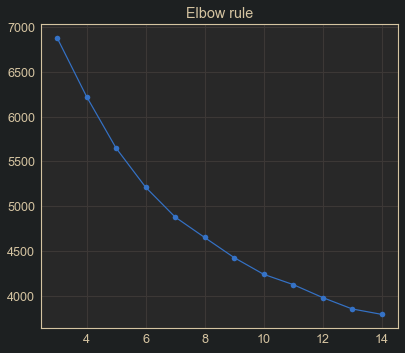

In [17]:
model_score = pd.Series(np.nan, index=range(3, 15));
for K in model_score.index:
    model = KMeans(n_clusters=K)
    model.fit(X)
    model_score[K] = model.inertia_

model_score.plot(title='Elbow rule', marker='o');

In [18]:
# Elbow rule shows us (empirically) 6 -- number of clusters.
model = KMeans(
    n_clusters=6
    , init='k-means++'
    , n_init=30
    , max_iter=300
    , tol=0.0001
    , random_state=17
    , algorithm='auto'
)
model.fit(X);

In [19]:
# Functions to visualise mean values for each cluster
def background_gradient(df):
    new_df = df.copy()
    new_df.loc[:, :] = ''
    norm = colors.Normalize(-1, 1)
    for column in df.columns:
        if column == 'overall':
            continue
        color_values = (clusters[column] - clusters['overall']) / clusters['overall']
        normed = norm(color_values.values)
        c = [colors.rgb2hex(x) for x in plt.cm.get_cmap('viridis')(normed)]
        new_df[column] = ['background-color: %s' % color for color in c]    
    return new_df


def get_cluster_means(df_orig, labels):
    df = df_orig.copy()
    df_mean = df.mean()
    clusters = df_mean.copy().to_frame('overall')
    for cluster_id in set(labels):
        cluster_mean = df.reset_index(drop=True)[labels == cluster_id].mean().to_frame(cluster_id)
        clusters = pd.concat([clusters, cluster_mean], axis=1)
    return clusters

In [20]:
clusters = get_cluster_means(df_credits, model.labels_)
clusters.style.apply(background_gradient, axis=None)

,overall,0,1,2,3,4,5
Age,35.546000,36.887097,31.541284,35.834625,33.845588,36.790000,43.639175
Sex,0.690000,0.677419,0.000000,1.000000,0.801471,0.680000,0.865979
Job,1.904000,1.774194,1.784404,1.782946,2.286765,1.850000,2.257732
Housing,0.395000,0.354839,0.357798,0.139535,0.154412,0.320000,1.938144
Saving accounts,0.373000,0.354839,0.110092,0.126615,0.183824,2.440000,0.092784
Checking account,0.458000,3.000000,0.270642,0.271318,0.397059,0.230000,0.319588
Credit amount,3271.258000,2135.419355,2184.880734,2258.211886,7567.580882,2349.410000,5407.195876
Duration,20.903000,16.951613,16.871560,16.514212,38.272059,17.810000,28.835052
Purpose,1.826000,1.806452,1.738532,1.658915,2.720588,1.760000,1.515464


In [21]:
pd.Series(model.labels_).value_counts()

2    387
1    218
3    136
4    100
5     97
0     62
dtype: int64

Resulting clusters in average are good for splitting loaners by: Credit ammount, Housing, Job, Duration.

For example we can say, that 6xth cluster is represented by people who rent housing, and are looking for a large credit for a long period of time. It is possible, that their loan puprose is morgage.

## Hierarchical clusterisation

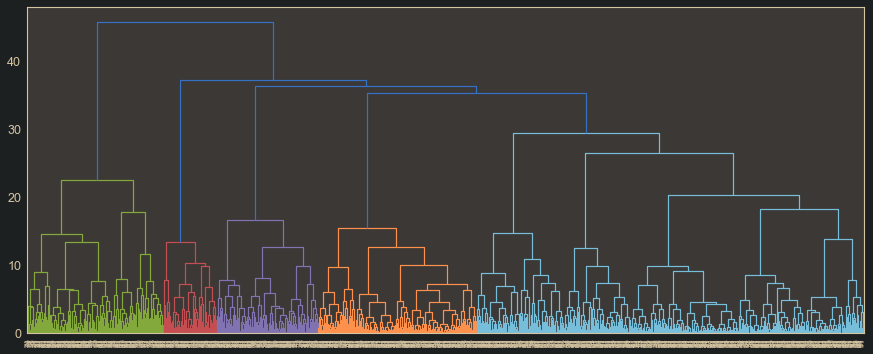

In [22]:
link = linkage(X, 'ward', 'euclidean')
fig, ax = plt.subplots(figsize=(15, 6))
dn = dendrogram(link, ax=ax)

In [23]:
# By dendrogramm we can see that 5 is good cluster number
labels = fcluster(link, 5, criterion='maxclust')

In [24]:
clusters = get_cluster_means(df_credits, labels)
clusters.style.apply(background_gradient, axis=None)

,overall,1,2,3,4,5
Age,35.546000,36.852761,37.671875,35.239669,28.947090,37.565875
Sex,0.690000,0.779141,0.687500,0.719008,0.000000,0.933045
Job,1.904000,2.300613,1.750000,1.900826,1.783069,1.835853
Housing,0.395000,0.619632,0.406250,0.223140,0.391534,0.360691
Saving accounts,0.373000,0.171779,0.343750,2.132231,0.084656,0.105832
Checking account,0.458000,0.368098,2.968750,0.206612,0.285714,0.278618
Credit amount,3271.258000,7861.595092,2161.984375,2310.909091,2153.650794,2515.747300
Duration,20.903000,38.484663,17.328125,17.669421,17.291005,17.526998
Purpose,1.826000,1.815951,1.750000,1.752066,1.761905,1.885529


Hierarchical clustering result gives us good cluster slitting by almost all factors, except Purpose and Age. Purpose and Age could also be unimportant, hence, could be excluded from dataset.

Also better (custom) metric could give better result.